<a href="https://colab.research.google.com/github/makhijakabir/machine-learning/blob/main/bayesClassifierESF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#An Email Spam Filter using the Baye's Classifier

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Imports

In [93]:
!pip install wordcloud

from os import walk
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image

#nltk.download('all')
%matplotlib inline

##Constants (All the constant file paths)

In [87]:
exampleFile = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/practice_email.txt'

spam1 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/spam_1'
spam2 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/spam_2'

notSpam1 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
notSpam2 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

spam = 1
notSpam = 0

vocabSize = 2500

dataJSON = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/exmail-test-data.json'
dataCSV = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/word-by-id.csv'

whaleFile = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/wordcloud_resources/whale-icon.png'
notSpamIcon = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
spamIcon = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

fontWordCloud = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'
fontWordCloudLight = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf'

##Reading Files

In [47]:
#Prints the complete file with all the information

stream = open(exampleFile, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [48]:
 #Prints only the body of the emails

isBody = False
mainList = []

stream = open(exampleFile, encoding='latin-1')

for line in stream:
    if isBody:
        mainList.append(line)
    elif line == '\n':
        isBody = True

stream.close()

finalBody = '\n'.join(mainList)
print(finalBody)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

##Extraction of all the EMail Bodies using generator functions

In [49]:
def emailBodyGen(path):

    for root, dirname, filenames in walk(path):
        for fileName in filenames:

            filepath = join(root, fileName)

            stream = open(filepath, encoding='latin-1')

            isBody = False
            mainList = []

            for line in stream:
                if isBody:
                    mainList.append(line)
                elif line == '\n':
                    isBody = True

            stream.close()

            finalBody = '\n'.join(mainList)
            
            yield fileName, finalBody

In [50]:
def dfFromDir(path, classify):
    
    rows = []
    rowNames = []

    for fileName, finalBody in emailBodyGen(path):
        rows.append({'CATEGORY': classify, 'MESSAGE': finalBody})
        rowNames.append(fileName)

    return pd.DataFrame(rows, index=rowNames) 

In [51]:
#Storing the spam emails in a spamEmails dataframe

spamEmails = dfFromDir(spam1, spam)
spamEmails = spamEmails.append(dfFromDir(spam2, spam))
spamEmails

,CATEGORY,MESSAGE
00273.0c7d73771d79e84e2aab8c909c5bb210,1,This is a multi-part message in MIME format.\n...
00154.b6c448ccff434e2dbe2c7c200a36aa31,1,"On January 1st 2002, the European countries be..."
00223.349b9b0748ee72bad60729ffaae2cc00,1,This is a multi-part message in MIME format.\n...
00351.fd1b8a6cd42e81125fb38c2660cd9317,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E..."
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
...,...,...
00521.70417de823222858b4100b6030a64168,1,BUY 2 ADULT DVDs AT REGULAR PRICE AND GET A TH...
00484.602c7afb217663a43dd5fa24d97d1ca4,1,------=_NextPart_000_0066_62CFF34B.9C652FBA\n\...
00580.c3b23134b4767f5e796d0df997fede33,1,\n\n<html>\n\n\n\n<head>\n\n</head>\n\n\n\n<bo...
00320.a4e760741d537aef50c4c0b950329225,1,<=21DOCTYPE HTML PUBLIC =22-//W3C//DTD HTML 4....


In [52]:
#Storing non spam emails in a notSpaEmails dataframe

notSpamEmails = dfFromDir(notSpam1, notSpam)
notSpamEmails = notSpamEmails.append(dfFromDir(notSpam2, notSpam))
notSpamEmails

,CATEGORY,MESSAGE
01565.c10c0b0e0c9903345e28f9c17fc84400,0,\n\n--iJXiJc/TAIT2rh2r\n\nContent-Type: text/p...
01433.4392b7c4884f0f218e74a0b86cc5b8c3,0,"\n\n""zeek"" said:\n\n\n\n> This was thoroughly ..."
01413.d1561ddcf3ead3a670b4516b3337216c,0,"> > Is the use of ""trusted hardware"" really wo..."
01856.c021a63248e3e6a2e151b67689d75e13,0,URL: http://diveintomark.org/archives/2002/09/...
01498.e0d9701d1bf2798b86efb602a44d072b,0,http://www.hughes-family.org/bugzilla/show_bug...
...,...,...
00695.2de9d6d30a7713e550b4fd02bb35e7b4,0,"""This is a very tenuous time for Microsoft,"" G..."
01137.e0afde7fc471f626742746c738013750,0,On 21 Jul 2002 23:59:59 +1200\n\nMark Derricut...
01294.7f208bf4ae152863fd40f25e2e121d49,0,Pablo Sofware Solutions FTP server Directory T...
00747.352d424267d36975a7b40b85ffd0885e,0,"If you run Pick, and then use the ""New FTOC"" b..."


In [53]:
#Conacatenating the 2 dataframes to create a collusive dataframe for all the values

data = pd.concat([spamEmails, notSpamEmails])
data

,CATEGORY,MESSAGE
00273.0c7d73771d79e84e2aab8c909c5bb210,1,This is a multi-part message in MIME format.\n...
00154.b6c448ccff434e2dbe2c7c200a36aa31,1,"On January 1st 2002, the European countries be..."
00223.349b9b0748ee72bad60729ffaae2cc00,1,This is a multi-part message in MIME format.\n...
00351.fd1b8a6cd42e81125fb38c2660cd9317,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E..."
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
...,...,...
00695.2de9d6d30a7713e550b4fd02bb35e7b4,0,"""This is a very tenuous time for Microsoft,"" G..."
01137.e0afde7fc471f626742746c738013750,0,On 21 Jul 2002 23:59:59 +1200\n\nMark Derricut...
01294.7f208bf4ae152863fd40f25e2e121d49,0,Pablo Sofware Solutions FTP server Directory T...
00747.352d424267d36975a7b40b85ffd0885e,0,"If you run Pick, and then use the ""New FTOC"" b..."


##Data Cleaning and Checking for Missing Values

In [54]:
#Check if there are any missing values
data['MESSAGE'].isnull().values.any() #Returns true if there are any missing values


False

In [55]:
#Check if there are any empty emails with the string length of 0
(data.MESSAGE.str.len() == 0).any()

True

In [56]:
#Check how many entries have the string length of 0
(data.MESSAGE.str.len() == 0).sum()

3

In [57]:
#Getting the index of all the rows where the string length is 0
data[(data.MESSAGE.str.len() == 0)]

,CATEGORY,MESSAGE
cmds,1,
cmds,1,
cmds,0,


##Removing a and Renaming Entries from the Dataset

In [58]:
#cmds is  the ID of the column that refers to the null data

data.drop(['cmds'], inplace=True)

In [59]:
 #Adding Document IDs to track EMail IDs

documentIDs = range(0, len(data.index))
data['DOC_ID'] = documentIDs
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,This is a multi-part message in MIME format.\n...,00273.0c7d73771d79e84e2aab8c909c5bb210
1,1,"On January 1st 2002, the European countries be...",00154.b6c448ccff434e2dbe2c7c200a36aa31
2,1,This is a multi-part message in MIME format.\n...,00223.349b9b0748ee72bad60729ffaae2cc00
3,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...",00351.fd1b8a6cd42e81125fb38c2660cd9317
4,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
...,...,...,...
5791,0,"""This is a very tenuous time for Microsoft,"" G...",00695.2de9d6d30a7713e550b4fd02bb35e7b4
5792,0,On 21 Jul 2002 23:59:59 +1200\n\nMark Derricut...,01137.e0afde7fc471f626742746c738013750
5793,0,Pablo Sofware Solutions FTP server Directory T...,01294.7f208bf4ae152863fd40f25e2e121d49


##Saving the dataframe to the disk

In [60]:
data.to_json(dataJSON)

##Data Visualization through Pie Charts and Donut Charts



In [61]:
spamCounts = data.CATEGORY.value_counts()[0]
notSpamCounts = data.CATEGORY.value_counts()[1]

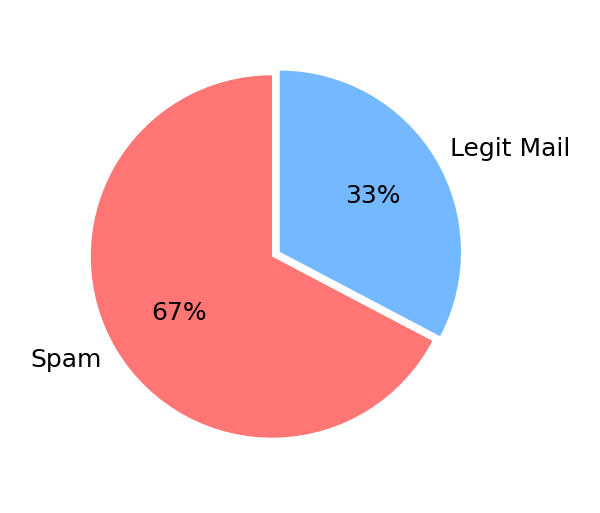

In [62]:
#Creating a pie chart

categoryNames = ['Spam', 'Legit Mail']
size = [spamCounts, notSpamCounts]
colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=300)
plt.pie(size, labels=categoryNames, textprops={'fontsize': 6}, autopct='%1.0f%%', colors=colors, explode=[0, 0.05], startangle=90)
plt.show()

##Natural Language Processing

###Text Pre-Processing Techniques

In [63]:
#converting to lower case examples
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

###Downloading NLTK Resources

In [64]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [65]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [66]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to /root/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

###Tokenising: Segregating all the constituent words of the text.

In [67]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

###Removing Stop Words: Removing words like the, a, an, is, etc.

In [68]:
stopWords = set(stopwords.words('english'))

In [69]:
msg = 'All work and no play makes Jack a dull boy. TO be or not to be.'
words = word_tokenize(msg.lower())

filteredWords = []

for i in words:
    if i not in stopWords:
        filteredWords.append(i)

filteredWords

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

###Word stems and stemming

In [70]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filteredWords = []

for i in words:
    if i not in stopWords:
        stemmedWord = stemmer.stem(i)
        filteredWords.append(stemmedWord)

print(filteredWords)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.']


###Removing Punctuations

In [71]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be???'
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filteredWords = []

for i in words:
    if i not in stopWords and i.isalpha():
        stemmedWord = stemmer.stem(i)
        filteredWords.append(stemmedWord)

print(filteredWords)

['work', 'play', 'make', 'jack', 'dull', 'boy']


###Removing HTML Tags

In [72]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
#soup.prettify() This method is used to print the html formatted text where the tags can be read in a better way.
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_20F213_01C25430.B7EDE5E0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: 7bit\n\n\n\n Outstanding\n\n Opportunities\n\n For Premier Producers\t\n\n Our Client\'s Search Includes:\t\n\n Full-Time Agents \t Sales Managers\t  General Agents\t \n\n CPA "Partners"\t  Independent Agents & Brokers\t \n\n \t Allow\n\n their "Nationally Acclaimed" marketing intiatives and unbeatable\n\nproduct portfolio to DOUBLE YOUR INCOME within 24 months\t\n\n\n\nPLUS ACCESS TO 385 OTHER COMPANIES \t\n\nFor A Confidential Phone Interview Please Complete Form & Submit \t\n\nName: \t \t\n\nE-mail: \t \t\n\nPhone: \t \t\n\nCity:\t  \tState:\t  \t \t \n\nArea of Interest:\t  \tFull-Time Agent\t  \tSales Manager\n\nGeneral Agent\t \n\n \t  \tCPA "Partner"\t  \tIndependent Agent\t \n\n \t    \t \t\n\n \n\nWe don\'t want anybody to receive or mailing who does not wish to receive\n\nthem. This is profess

###Function for Email Processing

In [73]:
def cleanMessage (message, stemmer=PorterStemmer(), stopWords = set(stopwords.words('english'))):

    soup = BeautifulSoup(message, 'html.parser')
    wordsNoHTML = soup.get_text()  

    words = word_tokenize(wordsNoHTML.lower())
    filteredWords = []  

    for i in words:
        if i not in stopWords and i.isalpha():
            filteredWords.append(stemmer.stem(i))

    return filteredWords

In [74]:
cleanMessage(data.at[2, 'MESSAGE'])

['messag',
 'mime',
 'format',
 'outstand',
 'opportun',
 'premier',
 'produc',
 'client',
 'search',
 'includ',
 'agent',
 'sale',
 'manag',
 'gener',
 'agent',
 'cpa',
 'partner',
 'independ',
 'agent',
 'broker',
 'allow',
 'nation',
 'acclaim',
 'market',
 'inti',
 'unbeat',
 'product',
 'portfolio',
 'doubl',
 'incom',
 'within',
 'month',
 'plu',
 'access',
 'compani',
 'confidenti',
 'phone',
 'interview',
 'pleas',
 'complet',
 'form',
 'submit',
 'name',
 'phone',
 'citi',
 'state',
 'area',
 'interest',
 'agent',
 'sale',
 'manag',
 'gener',
 'agent',
 'cpa',
 'partner',
 'independ',
 'agent',
 'want',
 'anybodi',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic',
 'outstand',
 'opportun',
 'premier',
 'produc',
 'agent',
 'sale',
 'manag',
 'gener',
 'agent',
 'cpa',
 'partner',
 'independ',
 'agent',
 'broker',
 'plu',
 'access',


##Apply Cleaning and Tokenisation to all the messages

In [75]:
#Creating a massive series of all the messages cleaned and transformed

%%time

nestedList = data.MESSAGE.apply(cleanMessage)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 42.8 s, sys: 234 ms, total: 43 s
Wall time: 43.1 s


In [76]:
spamID = data[data.CATEGORY == 1].index
notSpamID = data[data.CATEGORY == 0].index

In [77]:
spamListNested = nestedList.loc[spamID]
notSpamListNested = nestedList.loc[notSpamID]

spamListNested.shape

(1896,)

In [78]:
finalSpamList = [item for sublist in spamListNested for item in sublist]
spamWords = pd.Series(finalSpamList).value_counts()

spamWords[:10] #First 10 most common words and freuency of their occurance

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

In [79]:
finalNotSpamList = [item for sublist in notSpamListNested for item in sublist]
notSpamWords = pd.Series(finalNotSpamList).value_counts()

notSpamWords[:10] #First 10 most common words and freuency of their occurance

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

##Creating a Word Cloud

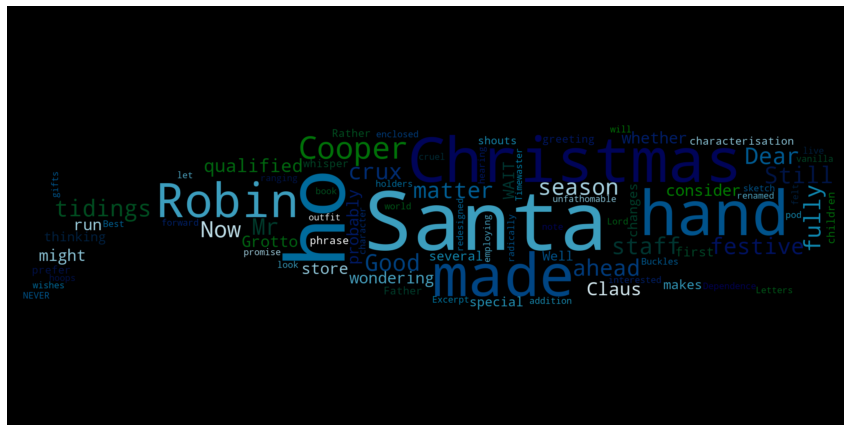

In [80]:
icon = Image.open(whaleFile)
imageMask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
imageMask.paste(icon, box=icon)

rgbArray = np.array(imageMask)

wordCloud = WordCloud(mask=rgbArray, colormap='ocean')

wordCloud.generate(finalBody)
plt.figure(figsize=(15, 8))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##Word Cloud of Not Spam and Spam Messages

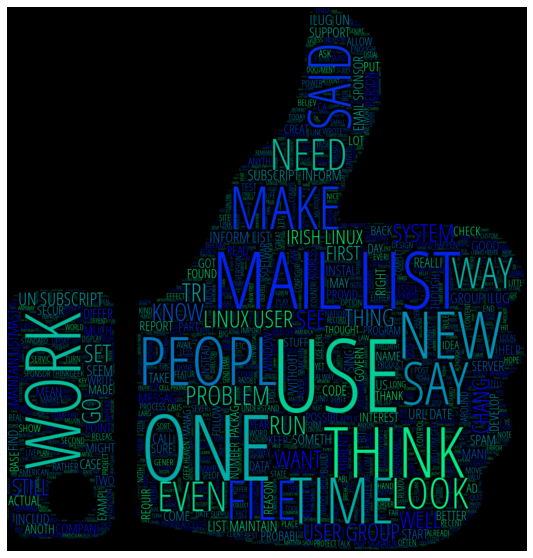

In [81]:
#NOT SPAM EMAILS

icon = Image.open(notSpamIcon)
imageMask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
imageMask.paste(icon, box=icon)

rgbArray = np.array(imageMask)

notSpamStr = ' '.join(finalNotSpamList)

wordCloud = WordCloud(mask=rgbArray, max_words=2000, colormap='winter', font_path=fontWordCloudLight, max_font_size=300)

wordCloud.generate(notSpamStr.upper())
plt.figure(figsize=(10, 10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

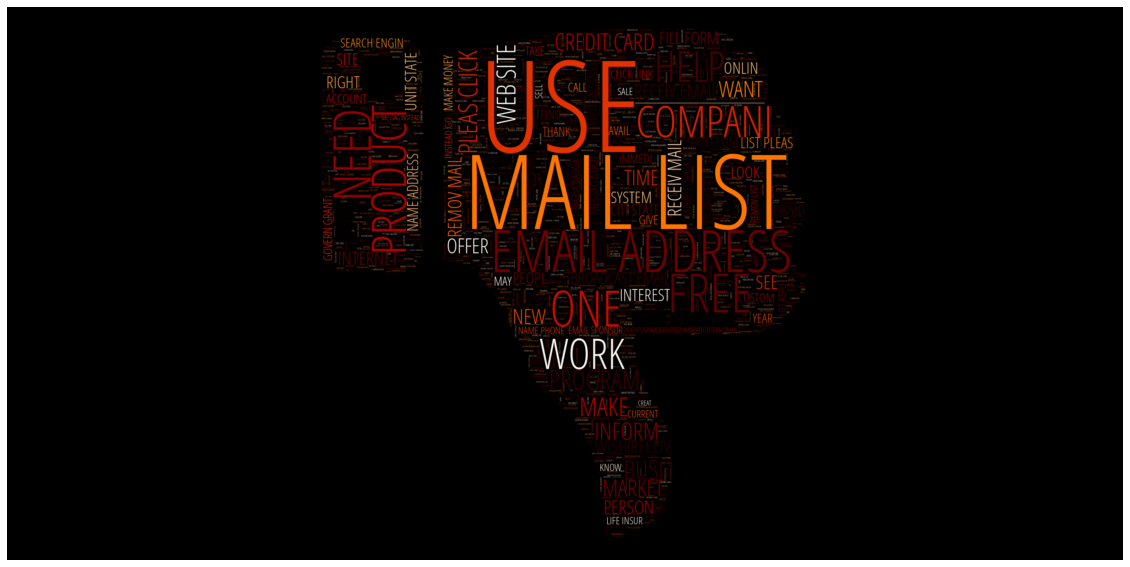

In [82]:
#NOT SPAM EMAILS

icon = Image.open(spamIcon)
imageMask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
imageMask.paste(icon, box=icon)

rgbArray = np.array(imageMask)

spamStr = ' '.join(finalSpamList)

wordCloud = WordCloud(mask=rgbArray, max_words=2000, colormap='gist_heat', font_path=fontWordCloudLight, max_font_size=300)

wordCloud.generate(spamStr.upper())
plt.figure(figsize=(20, 20))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##Generate a Vocabulary and a Dictionary 

In [83]:
stemmedNested = data.MESSAGE.apply(cleanMessage)
flatStemmed = [item for sublist in stemmedNested for item in sublist]

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [84]:
uniqueWords =  pd.Series(flatStemmed).value_counts()
print('No. of unique words', uniqueWords.shape[0])
uniqueWords.head()

No. of unique words 27294


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [85]:
frequentWords = uniqueWords[0:vocabSize]
print('The most common 10 words are:\n', frequentWords[:10])

The most common 10 words are:
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


##Create a Vocabulary DataFame with a wordID

In [86]:
wordID = list(range(0, vocabSize))
vocab = pd.DataFrame({'vocabWords':frequentWords.index.values}, index=wordID)
vocab.index.name = 'wordIDs'
vocab.head()

,vocabWords
wordIDs,
0,http
1,use
2,list
3,email
4,get


##Save the vocab dataframe as a csv file

In [88]:
vocab.to_csv(dataCSV, index_label=vocab.index.name, header=vocab.vocabWords.name)

##Generate Features and a Sparse Matrix

###Creating a DataFrame with one word per column

In [92]:
wordsColumnDF = pd.DataFrame.from_records(stemmedNested.tolist())
wordsColumnDF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
0,messag,mime,format,prulif,univers,protector,prulif,univers,plu,rock,case,close,perman,life,insur,afford,rate,whether,client,look,pay,minimum,premium,need,polici,specif,age,pay,suffici,premium,need,death,benefit,life,prudenti,answer,prulif,univers,protectorsm,offer,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,januari,european,countri,began,use,new,euro,never,mani,countri,power,economi,unit,use,singl,currenc,get,piec,histori,would,like,send,free,euro,free,report,world,currenc,visit,site,request,euro,euro,report,http,addit,currenc,report,receiv,free,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,outstand,opportun,premier,produc,client,search,includ,agent,sale,manag,gener,agent,cpa,partner,independ,agent,broker,allow,nation,acclaim,market,inti,unbeat,product,portfolio,doubl,incom,within,month,plu,access,compani,confidenti,phone,interview,pleas,complet,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,untitl,attent,must,comput,user,packag,deal,norton,systemwork,oftwar,suit,includ,six,ye,util,special,low,price,util,great,price,combin,retail,valu,free,ship,click,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,save,life,insur,spend,life,quot,save,g,famili,financi,secur,import,life,quot,save,ke,buy,life,insur,simpl,afford,provid,free,access,best,compani,lowest,rate,life,quot,save,fast,save,money,let,us,help,get,start,best,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791,tenuou,time,microsoft,gartenberg,said,time,microsoft,histori,seen,tri,real,netscap,rrrrrrriiiiiight,http,juli,realnetwork,pose,challeng,microsoft,john,markoff,san,francisco,juli,signific,challeng,microsoft,realnetwork,plan,announc,new,version,softwar,monday,distribut,audio,video,rang,format,includ,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5792,jul,mark,derricutt,wrote,mon,che,wrote,server,mention,work,problem,rpm,provid,mail,list,http,redhat,rpm,http,http,redhat,rpm,http,http,that,correct,line,ad,repositori,instal,still,progress,mail,list,http,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5793,pablo,sofwar,solut,ftp,server,directori,travers,vulner,overview,oo,pablo,softwar,solut,ftp,server,version,build,show,file,directori,resid,outsid,no

###Splitting into a training and a testing dataset

In [94]:
xTrain, xTest, yTrain, yTest = train_test_split(wordsColumnDF, data.CATEGORY, test_size=0.3, random_state=42)

In [97]:
xTrain.index.name = xTest.index.name = 'docID'

###Creating a Sparse Matix for the Training Dataset

In [98]:
wordIndex = pd.Index(vocab.vocabWords)